In [1]:
import sys
sys.path.append("../") 

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='../data',cache=True,as_frame=False)
X=X/255.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [4]:
import numpy as np
from hamiltonian import utils

num_examples,num_inputs=X_train.shape
num_outputs=len(np.unique(y_train))

#y_train=utils.one_hot(y_train,num_outputs)
#y_test=utils.one_hot(y_test,num_outputs)

In [5]:
y_train=np.int32(y_train)
y_test=np.int32(y_test)

### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [6]:
import mxnet as mx
from mxnet import nd, autograd, gluon
model_ctx=mx.cpu()
hyper={'alpha':10.}
in_units=X_train.shape[1]
out_units=len(np.unique(y_train))

In [11]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.05,ctx=model_ctx)

In [12]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


In [13]:
par,loss=inference.fit(epochs=10,batch_size=64,X_train=X_train,y_train=y_train,verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]


MXNetError: Traceback (most recent call last):
  File "/Users/sergio/mxnet/src/imperative/imperative.cc", line 217
MXNetError: Check failed: AGInfo: :IsNone(*output): Assigning to NDArrays that are already in a computational graph will cause undefined behavior when evaluating gradients. Please call backward first to clear the graph or do this out side of a record section. Also note that you cannot use inplace operations like +=, *=, relu(x, out=x), y[idx]=x, etc inside a record section. Issue occurred while recording op: _copyto

In [72]:
model.net.collect_params()

{'0.weight': Parameter (shape=(10, 784), dtype=float32),
 '0.bias': Parameter (shape=(10,), dtype=float32)}

In [40]:
model.net.collect_params()['0.bias'].data()


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<NDArray 10 @cpu(0)>

In [41]:
model.par['0.weight'].shape

(10, 784)

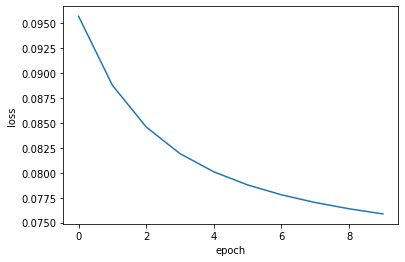

In [42]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [43]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [44]:
samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())

In [45]:
samples=np.asarray(samples)

In [46]:
samples[:,0]

array([5, 9, 8, 9, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 1, 3, 8, 5, 5, 8,
       8, 8, 8, 8, 8, 8, 5, 5, 5, 8, 8, 8, 5, 8, 5, 3, 8, 8, 8, 3, 8, 8,
       8, 8, 8, 9, 2, 5, 8, 8, 8, 8, 8, 5, 5, 3, 8, 5, 3, 8, 8, 8, 8, 8,
       5, 3, 8, 3, 5, 8, 3, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 2, 3, 1, 8, 8,
       8, 8, 3, 8, 5, 2, 8, 5, 8, 8, 8, 8])

In [47]:
y_test[0]

8

In [48]:
y_hat=np.quantile(samples,.9,axis=0)

In [49]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       1.00      0.30      0.46      1358
           1       0.99      0.08      0.15      1661
           2       0.56      0.17      0.26      1441
           3       0.38      0.15      0.22      1386
           4       0.24      0.03      0.06      1409
           5       0.12      0.10      0.11      1291
           6       0.51      0.72      0.59      1364
           7       0.36      0.32      0.34      1373
           8       0.26      0.79      0.39      1346
           9       0.34      0.96      0.51      1371

    accuracy                           0.36     14000
   macro avg       0.47      0.36      0.31     14000
weighted avg       0.49      0.36      0.30     14000



In [28]:
X_batch=nd.array(X_train[:32],ctx=model_ctx)
y_batch=nd.array(y_train[:32],ctx=model_ctx)

In [29]:
like=model.negative_log_likelihood(par,X_train=X_batch,y_train=y_batch)
prior=model.negative_log_prior(par)

# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [20]:
import mxnet as mx
from mxnet import nd, autograd, gluon, init
model_ctx=mx.cpu()
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}

In [21]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgld(model,par,step_size=0.05,ctx=model_ctx)

In [22]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgld)

<module 'hamiltonian.inference.sgld' from '../hamiltonian/inference/sgld.py'>

In [23]:
par,loss,posterior_samples=inference.fit(epochs=30,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

100%|██████████| 30/30 [05:12<00:00, 10.41s/it]


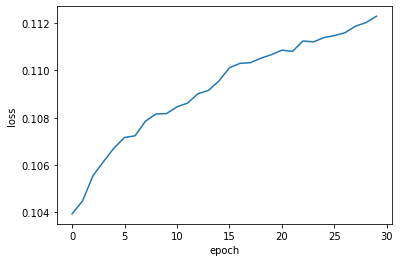

In [24]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [25]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [26]:
from sklearn.metrics import classification_report

samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1335
           1       0.87      0.94      0.90      1556
           2       0.00      0.00      0.00      1390
           3       0.68      0.88      0.77      1416
           4       0.82      0.88      0.85      1379
           5       0.78      0.77      0.78      1263
           6       0.75      0.93      0.83      1317
           7       0.90      0.88      0.89      1477
           8       0.68      0.82      0.75      1410
           9       0.83      0.84      0.84      1457

    accuracy                           0.79     14000
   macro avg       0.72      0.79      0.75     14000
weighted avg       0.72      0.79      0.75     14000



# Bayes by Backprop <a class="anchor" id="chapter3"></a>

In [123]:
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}

In [124]:
from hamiltonian.inference.bbb import bbb
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=bbb(model,par,step_size=0.05,ctx=model_ctx)

In [125]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.bbb)

<module 'hamiltonian.inference.bbb' from '../hamiltonian/inference/bbb.py'>

In [126]:
par,loss,(means,sigmas)=inference.fit(epochs=100,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

100%|██████████| 100/100 [05:32<00:00,  3.33s/it]


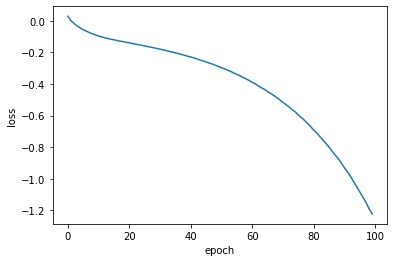

In [127]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [128]:
from sklearn.metrics import classification_report

def softplus(x):
    return nd.log(1. + nd.exp(x))

posterior=dict()
for var in par.keys():
    variational_posterior=mxp.normal.Normal(loc=means[var],
                                            scale=softplus(sigmas[var]))
    posterior.update({var:variational_posterior})
    
samples=[]
for _ in range(100):
    post_par=dict()
    for var in par.keys():
        post_par.update({var:posterior[var].sample().as_nd_ndarray()})
    y_pred=model.predict(post_par,nd.array(X_test,ctx=model_ctx))
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1332
           1       0.96      0.95      0.95      1593
           2       0.90      0.85      0.87      1386
           3       0.83      0.87      0.85      1429
           4       0.87      0.91      0.89      1413
           5       0.86      0.73      0.79      1284
           6       0.88      0.95      0.91      1353
           7       0.91      0.89      0.90      1454
           8       0.80      0.85      0.82      1358
           9       0.88      0.85      0.86      1398

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



# Posterior Diagnostics <a class="anchor" id="chapter4"></a>

In [55]:
import arviz as az

In [56]:
np.expand_dims(np.asarray([posterior_samples['bias'][0].asnumpy() for sample in posterior_samples['bias']]),0).shape

(1, 5, 10)

In [57]:
posterior_samples_numpy=dict()

for var in posterior_samples.keys():
    posterior_samples_numpy.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples[var]]),0)
        })


In [58]:
posterior_samples_numpy['weights'].shape

(1, 5, 784, 10)

In [59]:
dataset = az.convert_to_inference_data(posterior_samples_numpy)

In [60]:
ess=az.ess(dataset)

In [61]:
ess

<xarray.Dataset>
Dimensions:        (bias_dim_0: 10, weights_dim_0: 784, weights_dim_1: 10)
Coordinates:
  * weights_dim_0  (weights_dim_0) int64 0 1 2 3 4 5 ... 778 779 780 781 782 783
  * weights_dim_1  (weights_dim_1) int64 0 1 2 3 4 5 6 7 8 9
  * bias_dim_0     (bias_dim_0) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    weights        (weights_dim_0, weights_dim_1) float64 4.0 4.0 ... 4.0 4.0
    bias           (bias_dim_0) float64 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0

In [62]:
az.summary(dataset)

arviz - WARNING - Shape validation failed: input_shape: (1, 5), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"weights[0,0]",1.862,0.0,1.862,1.862,0.0,0.0,4.0,4.0,NaN
"weights[0,1]",-2.258,0.0,-2.258,-2.258,0.0,0.0,4.0,4.0,NaN
"weights[0,2]",-1.389,0.0,-1.389,-1.389,0.0,0.0,4.0,4.0,NaN
"weights[0,3]",-1.668,0.0,-1.668,-1.668,0.0,0.0,4.0,4.0,NaN
"weights[0,4]",-1.602,0.0,-1.602,-1.602,0.0,0.0,4.0,4.0,NaN
...,...,...,...,...,...,...,...,...,...
bias[5],0.509,0.0,0.509,0.509,0.0,0.0,4.0,4.0,NaN
bias[6],-0.058,0.0,-0.058,-0.058,0.0,0.0,4.0,4.0,NaN
bias[7],0.362,0.0,0.362,0.362,0.0,0.0,4.0,4.0,NaN
bias[8],-0.409,0.0,-0.409,-0.409,0.0,0.0,4.0,4.0,NaN


In [63]:
784*10+10

7850